<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/Brain_Tumor_Type_Classification_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Miscellaneous
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

#For data manipulation
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.callbacks import EarlyStopping

#For neural network
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator

In [3]:
#Load Training Data
train_data_dir = '/content/drive/MyDrive/Brain Tumor/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')

train_df = pd.concat([Fseries, Lseries], axis = 1)

In [4]:
#Load Testing Data
train_data_dir = '/content/drive/MyDrive/Brain Tumor/Testing'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

#Concatenate data paths
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name ='labels')

ts_df = pd.concat([Fseries, Lseries], axis = 1)

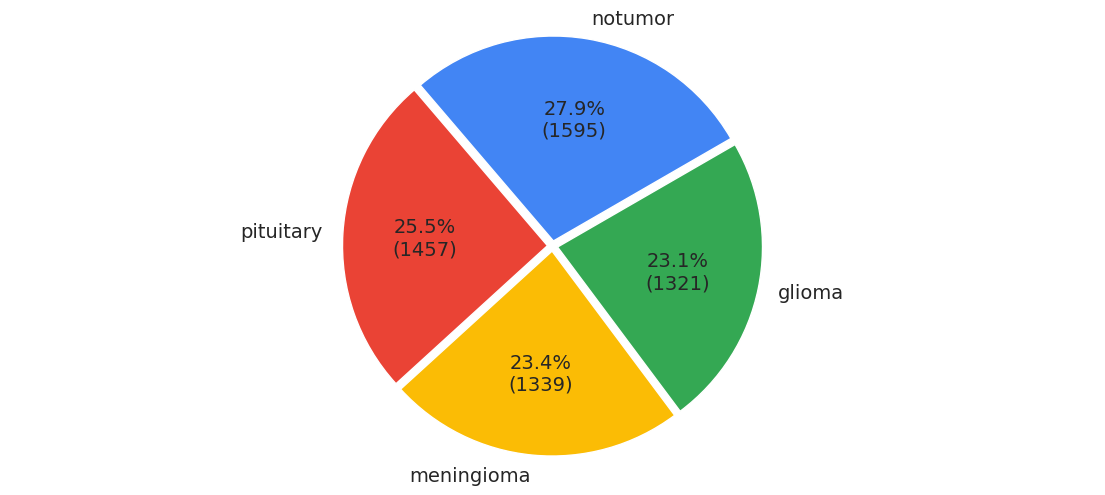

In [5]:
#Graph Dataset Split
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct * total / 100.0))
    return "{:.1f}%\n({:d})".format(pct, val)

# Adjust the explode argument to match the length of data_balance
explode = [0.025] * len(data_balance)

plt.pie(data_balance,
        labels = data_balance.index,
        autopct = custom_autopct,
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        explode = explode, # Use the adjusted explode here
        startangle = 30);
plt.axis('equal')
plt.show()

In [6]:
#Split dataset
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [7]:
#Augment and Preprocess Scans
batch_size = 32
img_size = (240, 240)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col = 'filepaths', y_col = 'labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


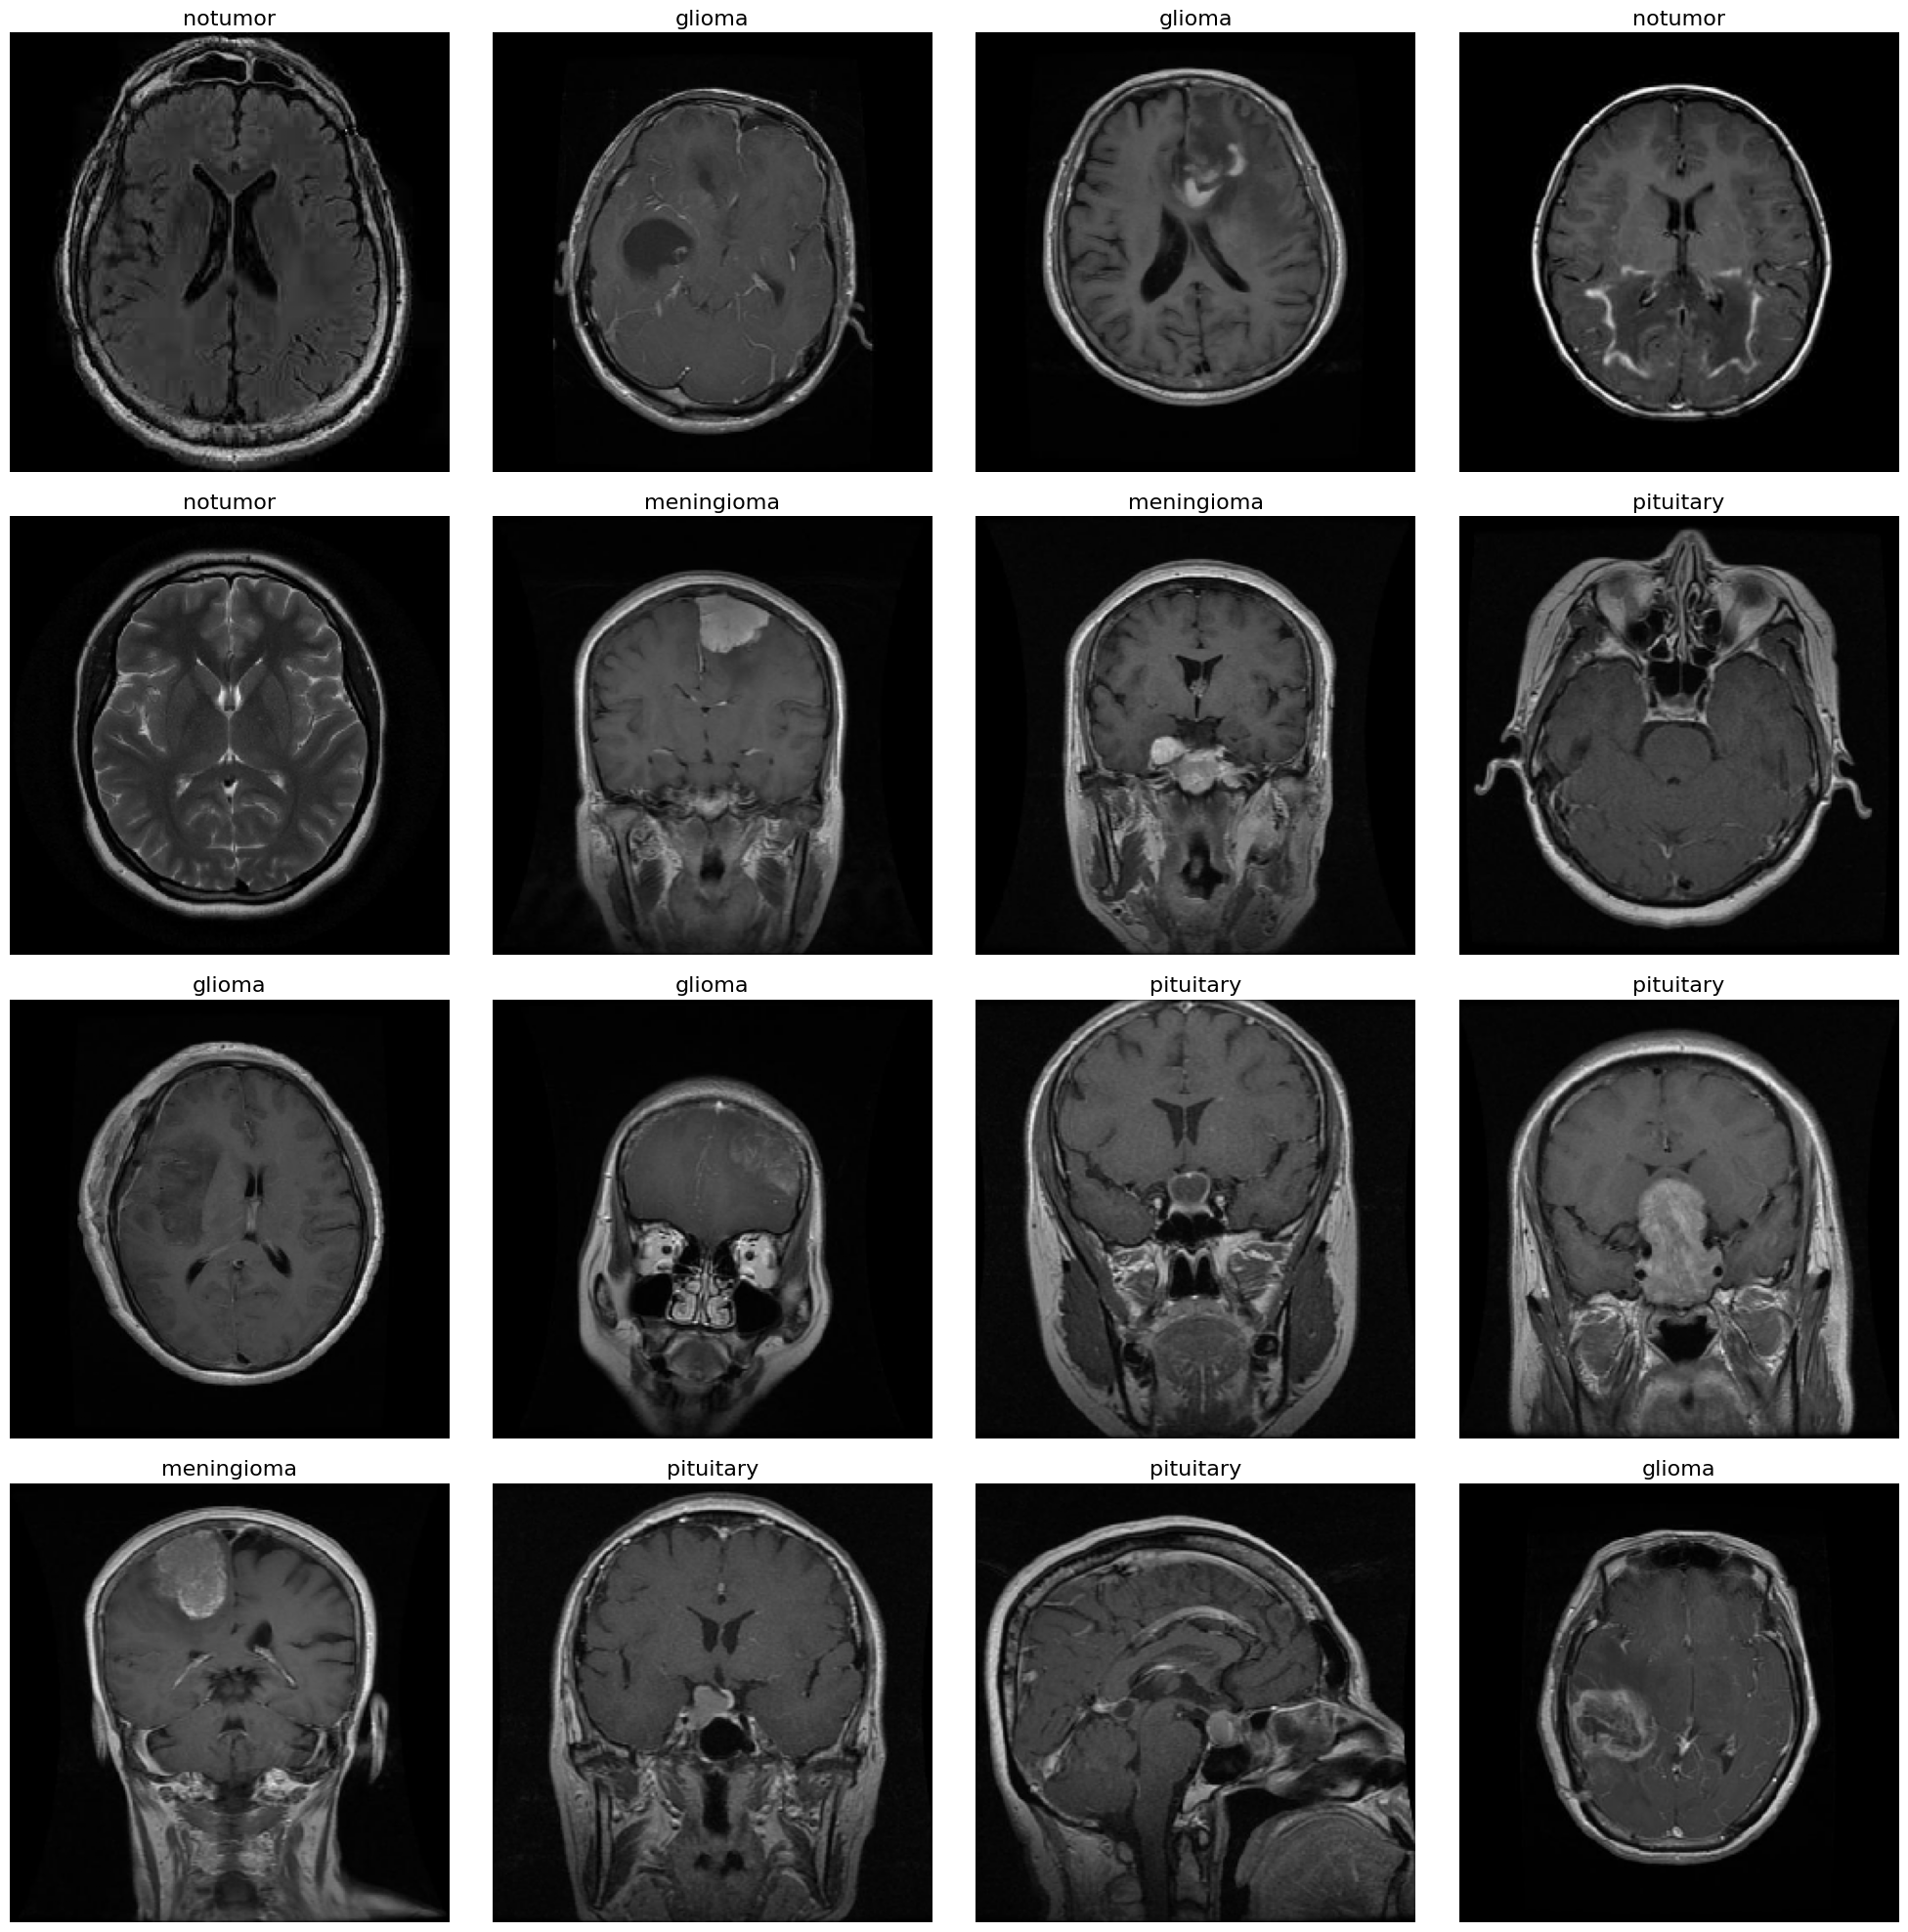

In [8]:
#Plot Processed Scans
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize = (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'black', fontsize = 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

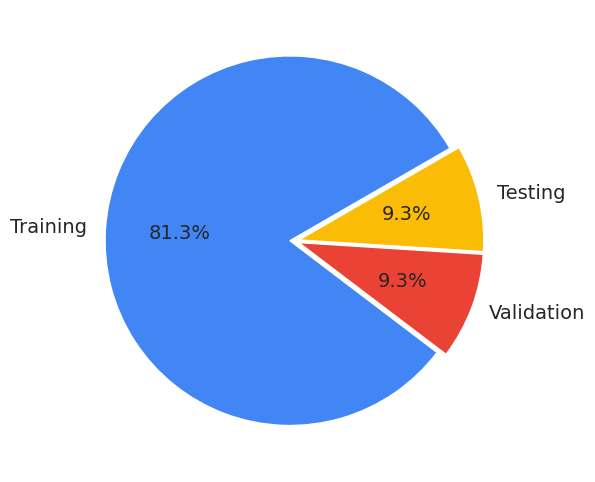

In [9]:
#Graph Dataset Directories
plt.figure(figsize = (14, 6))
plt.rcParams.update({'font.size': 14})

plt.pie([len(train_df), len(valid_df), len(test_df)],
        labels = ['Training','Validation', 'Testing'],
        colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853'],
        autopct = '%.1f%%',
        explode = (0.025, 0.025, 0.025),
        startangle = 30);

In [10]:
#Create model architecture
img_size = 240
class_count = len(list(train_gen.class_indices.keys()))

base_model = VGG19(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()

model.add(Input(shape = (img_size, img_size, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(class_count, activation = 'softmax'))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,236,292 (88.64 MB)

 Trainable params: 10,291,332 (39.26 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

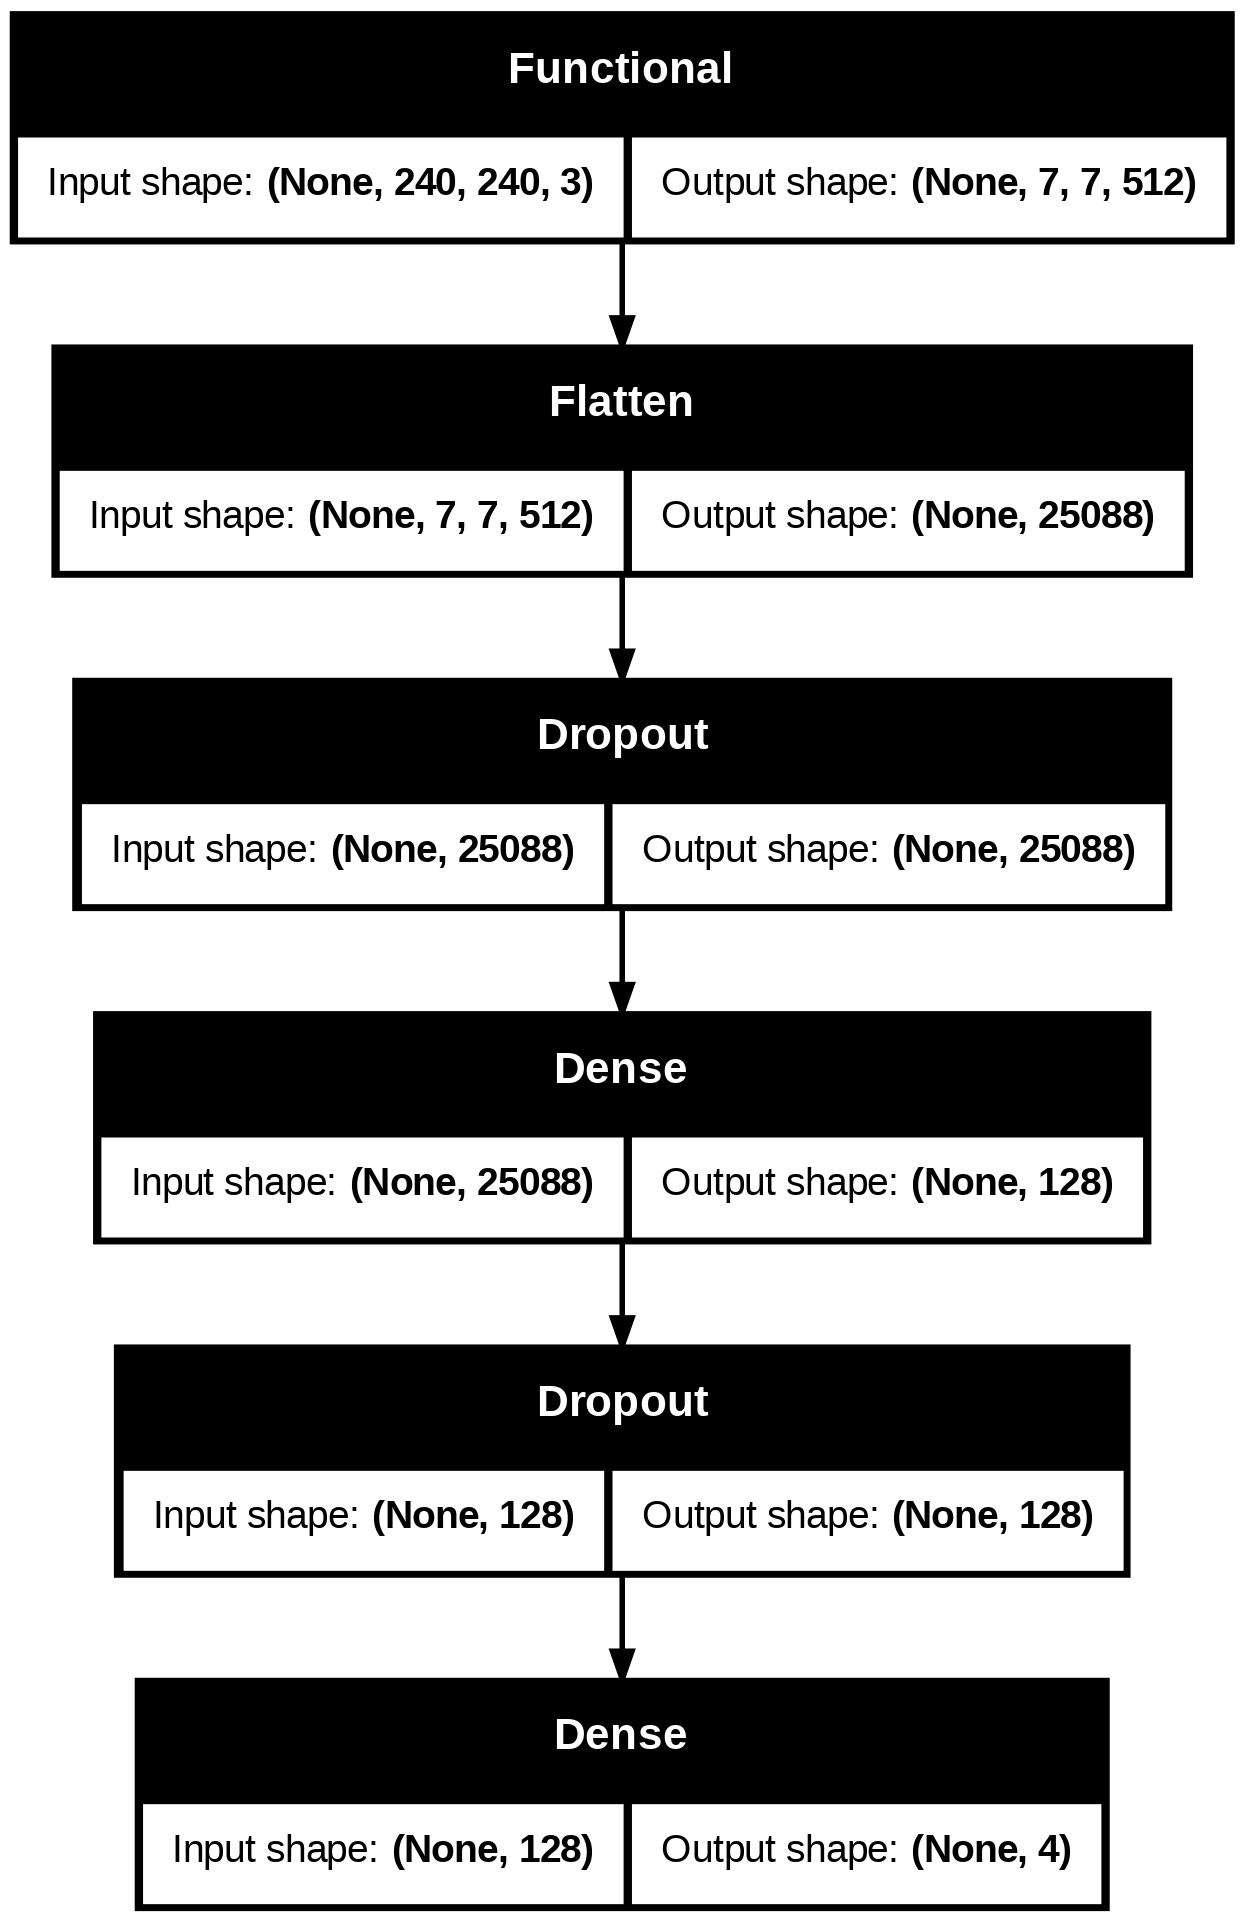

In [12]:
keras.utils.plot_model(model, show_shapes = True)

In [13]:
#LETS GO! NO ERRORS! Time to compile
model.compile(optimizer = Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


batch_size = 32
epochs = 90
history = model.fit(train_gen,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = valid_gen,
                    shuffle = False)

Epoch 1/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 2133s 12s/step - accuracy: 0.7132 - loss: 1.6974 - val_accuracy: 0.8656 - val_loss: 0.3240
Epoch 2/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 291ms/step - accuracy: 0.8976 - loss: 0.2872 - val_accuracy: 0.9298 - val_loss: 0.1993
Epoch 3/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 288ms/step - accuracy: 0.9448 - loss: 0.1633 - val_accuracy: 0.9267 - val_loss: 0.1846
Epoch 4/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 282ms/step - accuracy: 0.9561 - loss: 0.1125 - val_accuracy: 0.9557 - val_loss: 0.1283
Epoch 5/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 288ms/step - accuracy: 0.9704 - loss: 0.0887 - val_accuracy: 0.9588 - val_loss: 0.1280
Epoch 6/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 291ms/step - accuracy: 0.9792 - loss: 0.0628 - val_accuracy: 0.9725 - val_loss: 0.1146
Epoch 7/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.9785 - loss: 0.0562 - val_accuracy: 0.9695 - val_loss: 0.0794
Epoch 8/90
179/179 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.9872 - loss: 

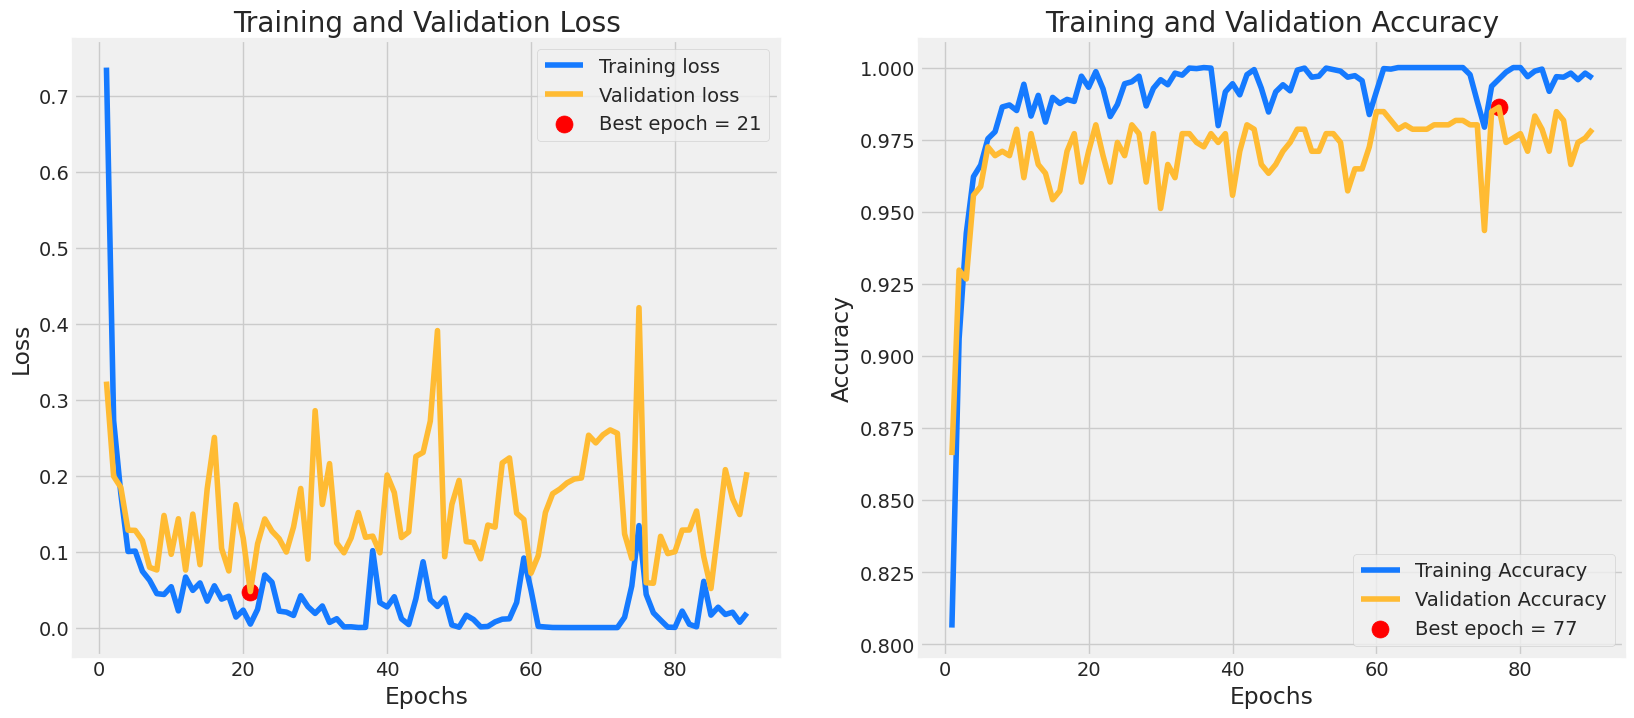

In [14]:
#Graph results
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

plt.figure(figsize = (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, color = '#157AFF', label = 'Training loss')
plt.plot(Epochs, val_loss, color = '#FFBB33', label = 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s = 150, color = 'red', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, color = '#157AFF', label = 'Training Accuracy')
plt.plot(Epochs, val_acc, color = '#FFBB33', label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s = 150, color = 'red', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [15]:
#Results for training, validating, testing
train_score = model.evaluate(train_gen, verbose = 1)
valid_score = model.evaluate(valid_gen, verbose = 1)
test_score = model.evaluate(test_gen, verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

179/179 ━━━━━━━━━━━━━━━━━━━━ 40s 225ms/step - accuracy: 0.9999 - loss: 5.1989e-04
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.9749 - loss: 0.2033
21/21 ━━━━━━━━━━━━━━━━━━━━ 236s 12s/step - accuracy: 0.9796 - loss: 0.3207
Train Loss:  0.0006821528077125549
Train Accuracy:  0.9998249411582947
--------------------
Validation Loss:  0.20471903681755066
Validation Accuracy:  0.9786259531974792
--------------------
Test Loss:  0.17634695768356323
Test Accuracy:  0.980182945728302


In [23]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step


In [24]:
#F1-score
print(classification_report(test_gen.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       151
  meningioma       0.95      0.97      0.96       153
     notumor       0.99      1.00      1.00       208
   pituitary       0.99      0.99      0.99       144

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [19]:
model.save('brain_tumor_model.h5')

In [20]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('brain_tumor_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpcyh1l2tj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132211311238928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311240272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311241232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311239504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311239120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311243536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311242384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311243344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311242768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311245072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13221131124

In [21]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('brain_tumor_model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpsz0s2_br'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132211311238928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311240272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311241232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311239504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311239120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311243536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311242384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311243344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311242768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132211311245072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13221131124

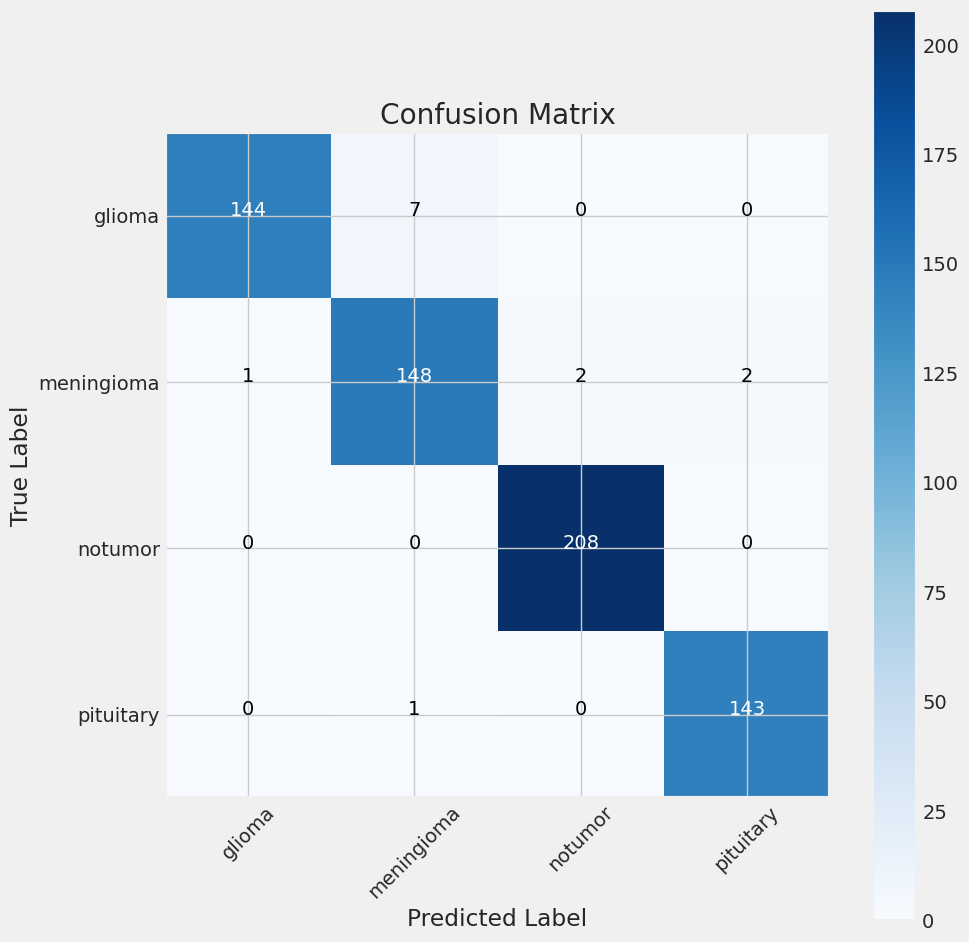

In [22]:
#Confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize = (10, 10))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()